In [4]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/fruit2c/fruit.csv
/kaggle/input/fruit2c/DATA2C/Dataset2C/cranberry/771.jpg
/kaggle/input/fruit2c/DATA2C/Dataset2C/cranberry/820.jpg
/kaggle/input/fruit2c/DATA2C/Dataset2C/cranberry/473.jpg
/kaggle/input/fruit2c/DATA2C/Dataset2C/cranberry/537.jpg
/kaggle/input/fruit2c/DATA2C/Dataset2C/cranberry/45.jpg
/kaggle/input/fruit2c/DATA2C/Dataset2C/cranberry/20.jpg
/kaggle/input/fruit2c/DATA2C/Dataset2C/cranberry/275.jpg
/kaggle/input/fruit2c/DATA2C/Dataset2C/cranberry/212.jpg
/kaggle/input/fruit2c/DATA2C/Dataset2C/cranberry/58.jpg
/kaggle/input/fruit2c/DATA2C/Dataset2C/cranberry/6.jpg
/kaggle/input/fruit2c/DATA2C/Dataset2C/cranberry/436.jpg
/kaggle/input/fruit2c/DATA2C/Dataset2C/cranberry/76.jpg
/kaggle/input/fruit2c/DATA2C/Dataset2C/cranberry/355.jpg
/kaggle/input/fruit2c/DATA2C/Dataset2C/cranberry/71.jpg
/kaggle/input/fruit2c/DATA2C/Dataset2C/cranberry/501.jpg
/kaggle/input/fruit2c/DATA2C/Dataset2C/cranberry/815.jpg
/kaggle/input/fruit2c/DATA2C/Dataset2C/cranberry/760.jpg
/kaggl

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os
import zipfile
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

Found 1610 images in 4 classes.


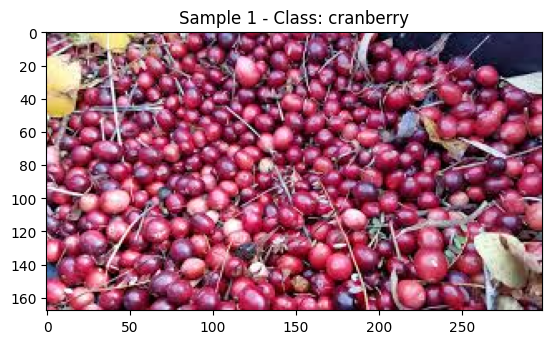

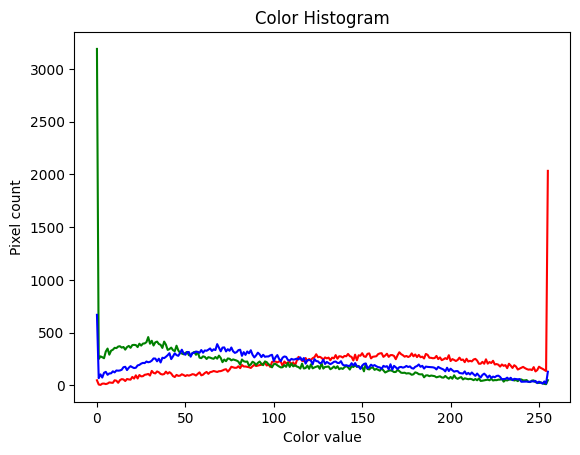

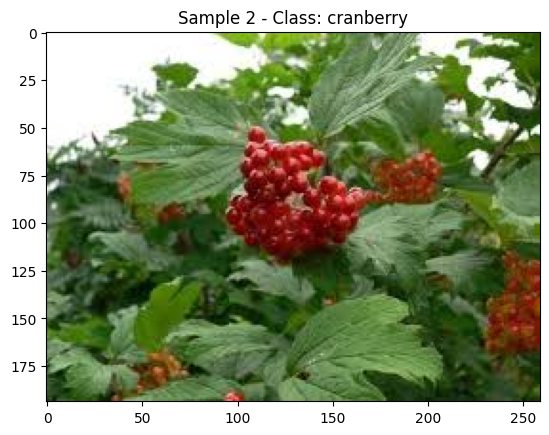

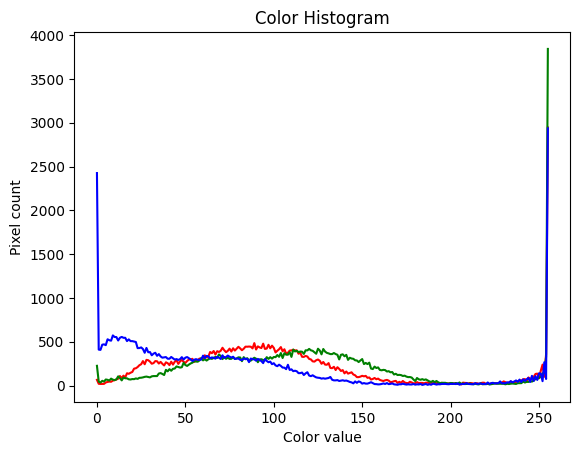

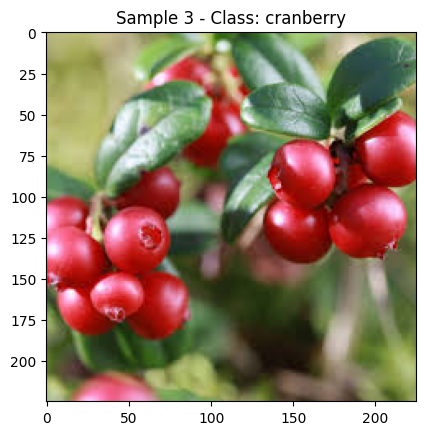

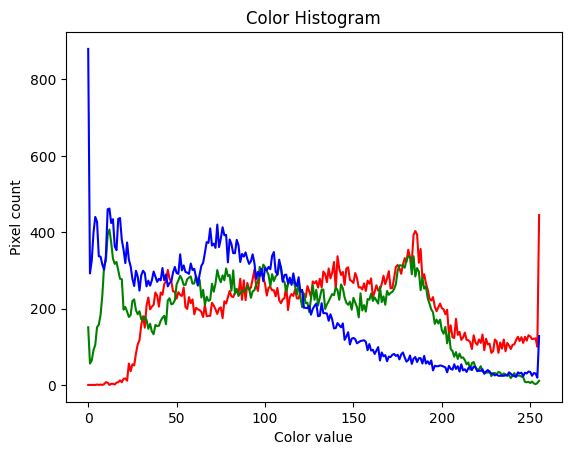

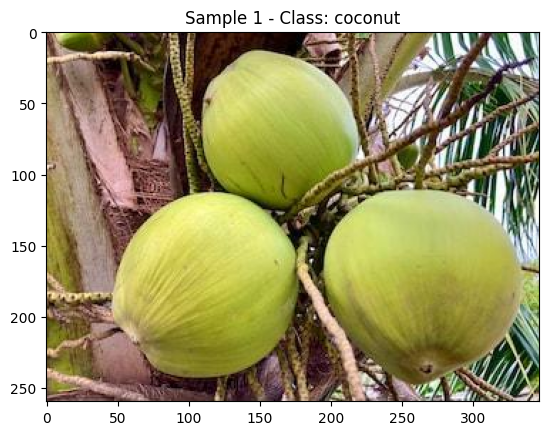

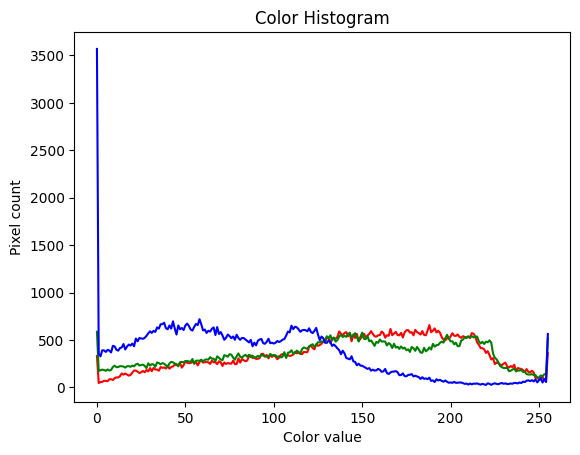

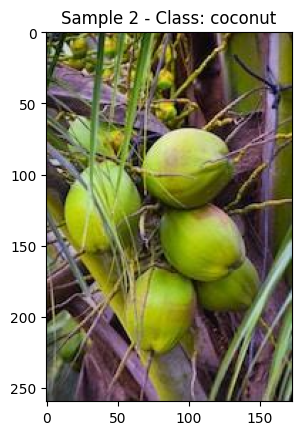

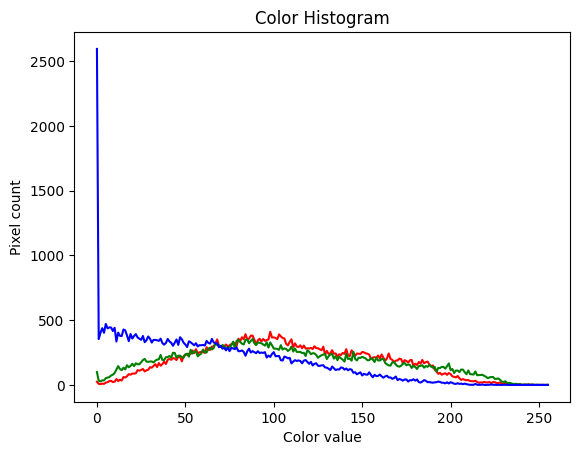

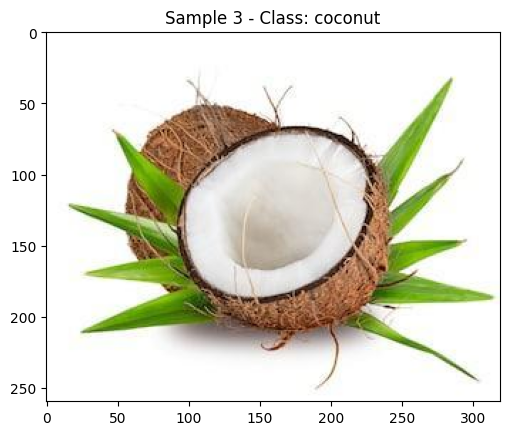

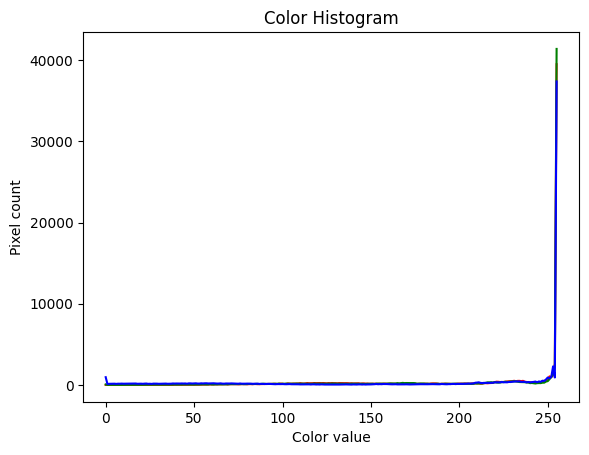

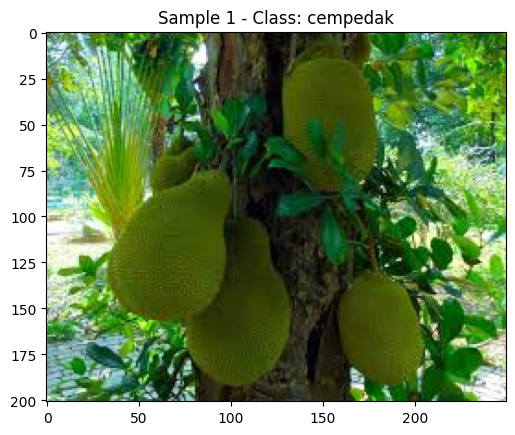

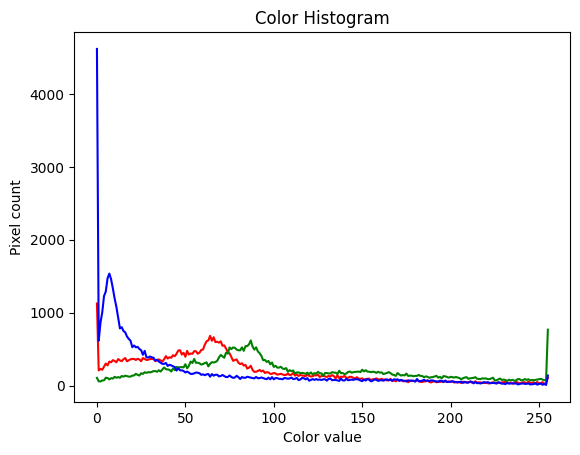

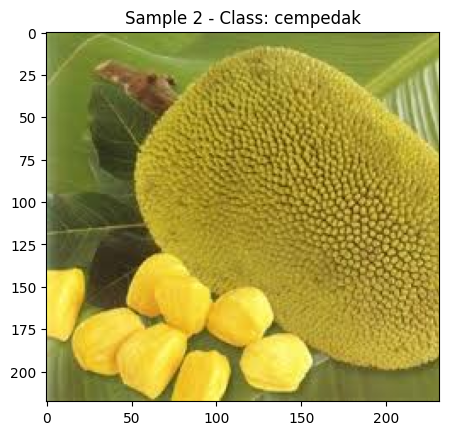

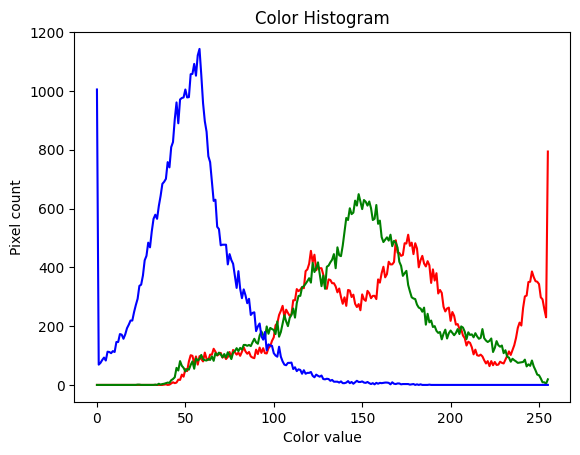

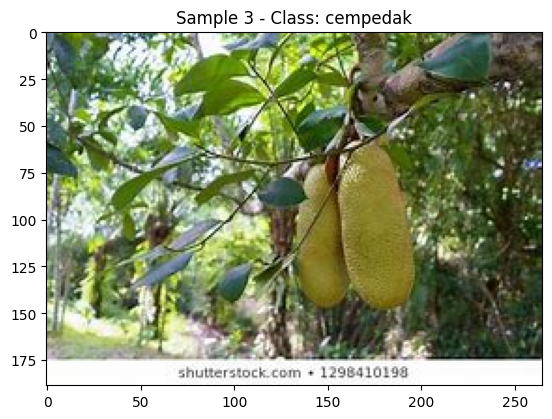

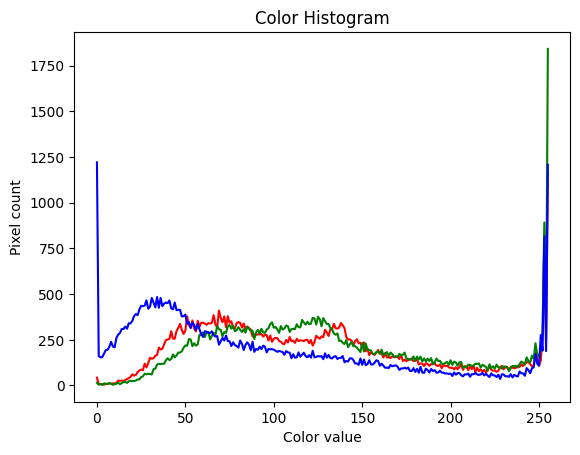

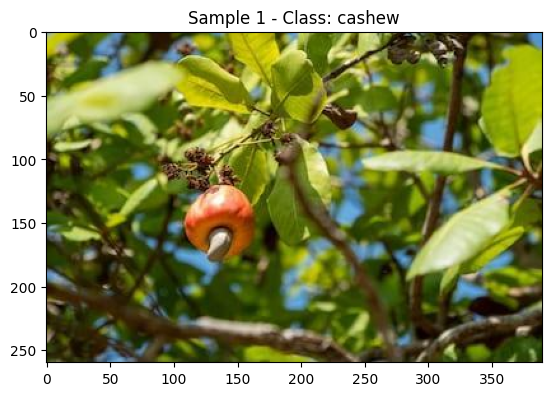

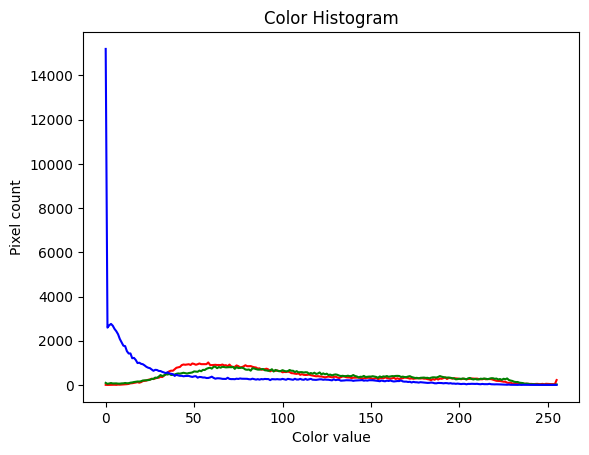

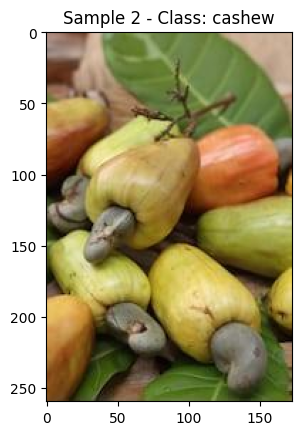

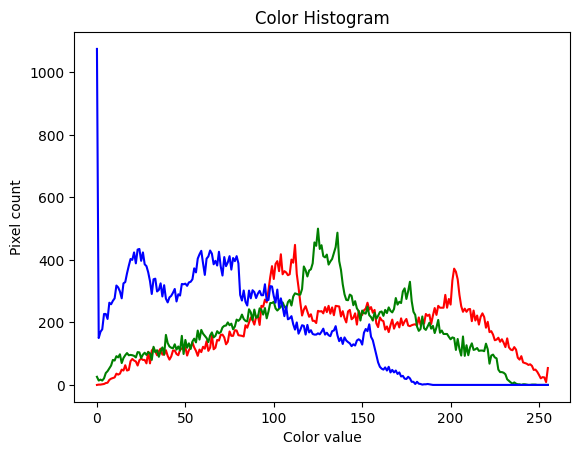

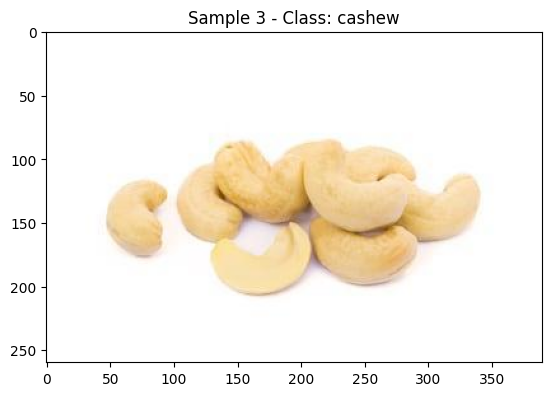

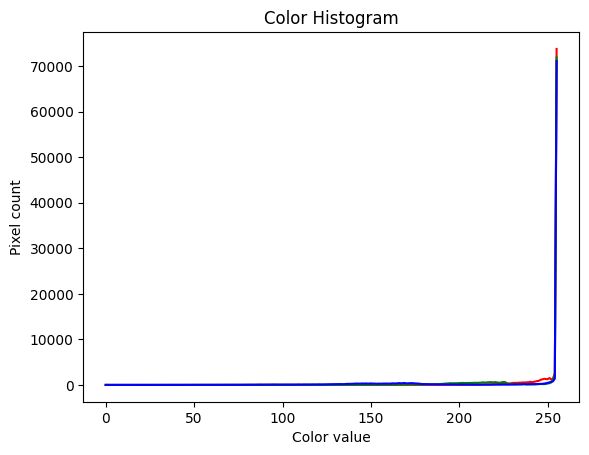

            Height        Width  Channels
count  1610.000000  1610.000000    1610.0
mean    231.452795   288.283851       3.0
std      78.943856   110.826611       0.0
min      75.000000   100.000000       3.0
25%     183.000000   210.000000       3.0
50%     225.000000   264.000000       3.0
75%     260.000000   389.000000       3.0
max     612.000000   833.000000       3.0


In [44]:
def explore_image(data, samples=3):
    image_paths = []
    labels = []
    for class_dir in os.listdir(data):
        class_path = os.path.join(data, class_dir)
        if os.path.isdir(class_path):
            for filename in os.listdir(class_path):
                image_path = os.path.join(class_path, filename)
                labels.append(class_dir)
                image_paths.append(image_path)

    print(f"Found {len(image_paths)} images in {len(set(labels))} classes.")

    # Display sample images for each class
    class_counts = {}
    for label in labels:
        class_counts[label] = 0

    for i, (image_path, label) in enumerate(zip(image_paths, labels)):
        if class_counts[label] < samples:
            img = cv2.imread(image_path)
            plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))  # Convert BGR to RGB
            plt.title(f"Sample {class_counts[label]+1} - Class: {label}")
            plt.show()
            class_counts[label] += 1

            # Visualize color histogram with the same colors as the image
            imgRGB = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            colors = ("red", "green", "blue")

            for channel_id, color in enumerate(colors):
                histo, bin_edges = np.histogram(
                    imgRGB[:, :, channel_id], bins=256, range=(0, 256)
                )
                plt.plot(bin_edges[0:-1], histo, color=color)

            plt.title("Color Histogram")
            plt.xlabel("Color value")
            plt.ylabel("Pixel count")
            plt.show()

    # Analyzing image dimensions
    dimensions = []
    for image_path in image_paths:
        img = cv2.imread(image_path)
        height, width, channels = img.shape
        dimensions.append([height, width, channels])
    df_dim = pd.DataFrame(dimensions, columns=["Height", "Width", "Channels"])
    print(df_dim.describe())  # Summary of image dimensions

    return labels, image_paths

data = r"/kaggle/input/fruit2c/DATA2C/Dataset2C"  
labels, image_paths = explore_image(data)


Found 1610 images in 4 classes.


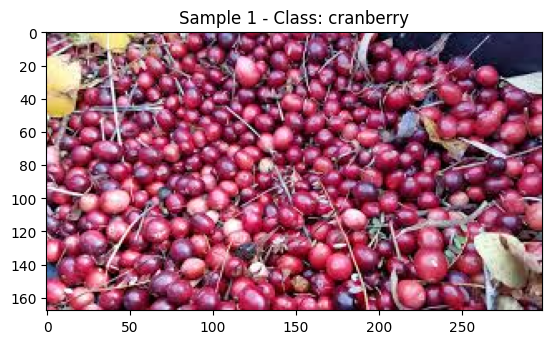

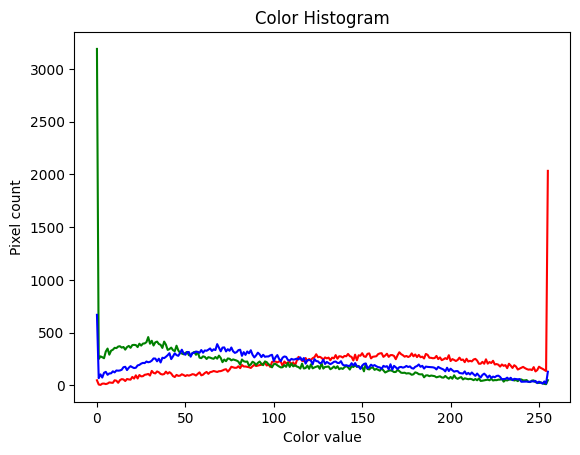

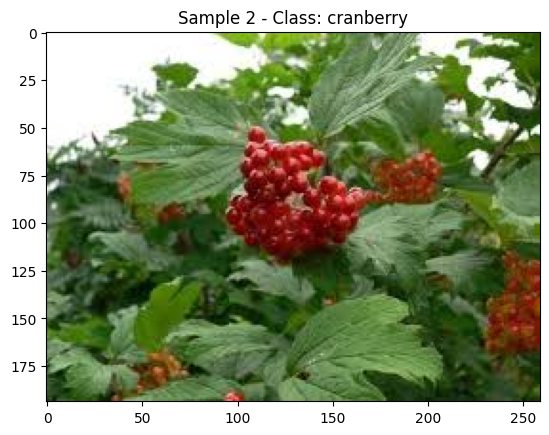

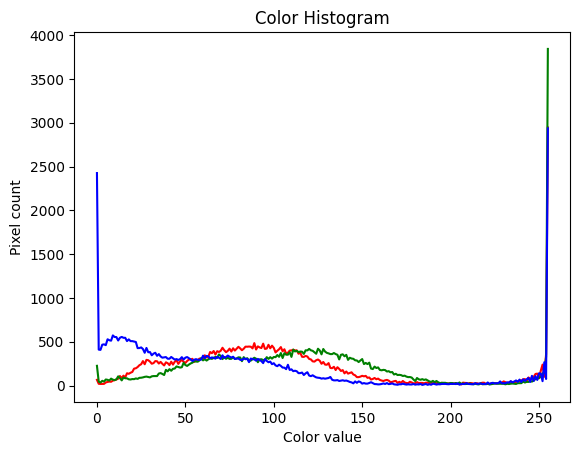

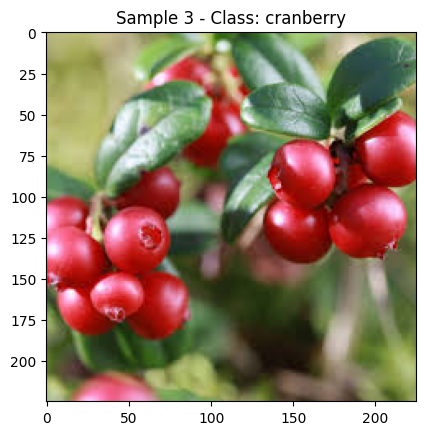

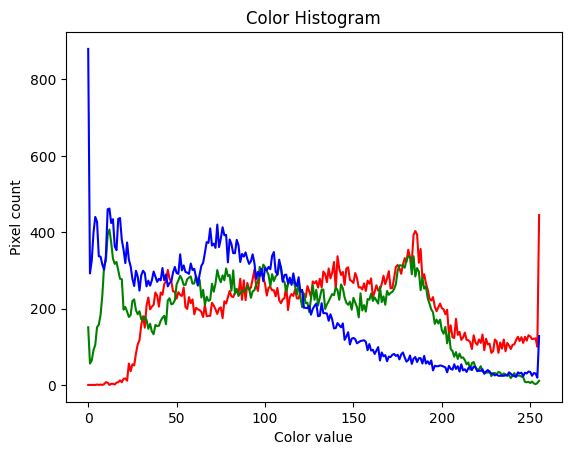

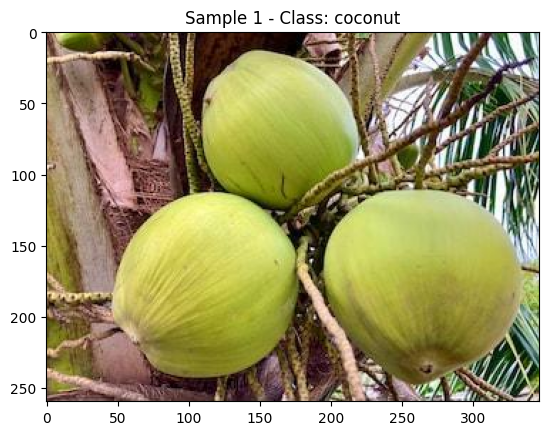

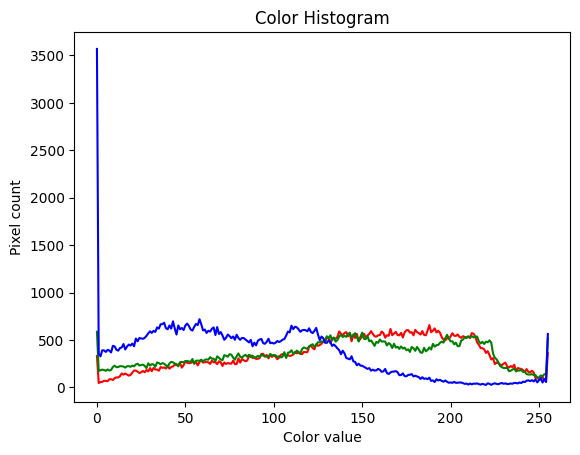

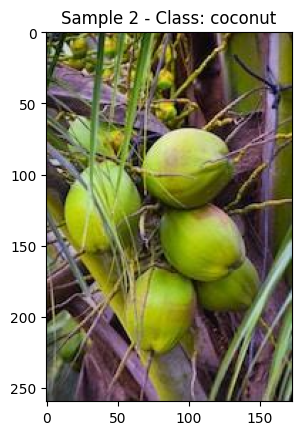

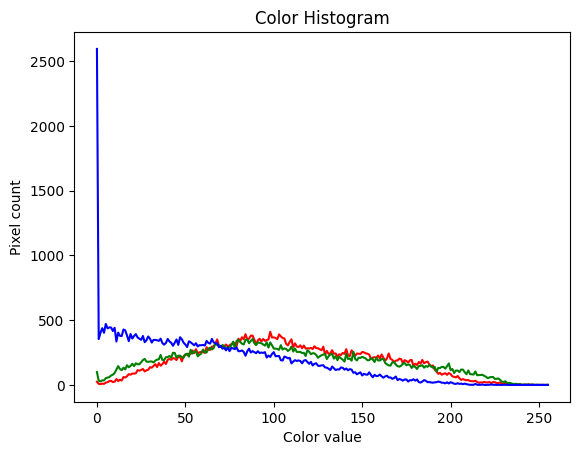

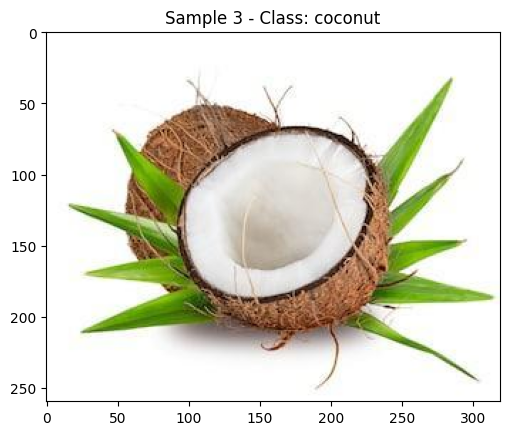

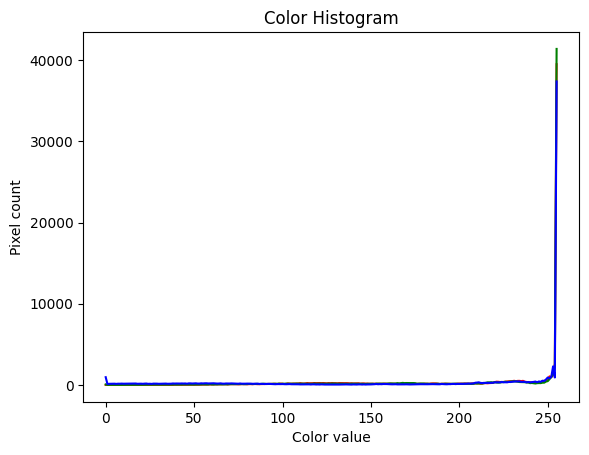

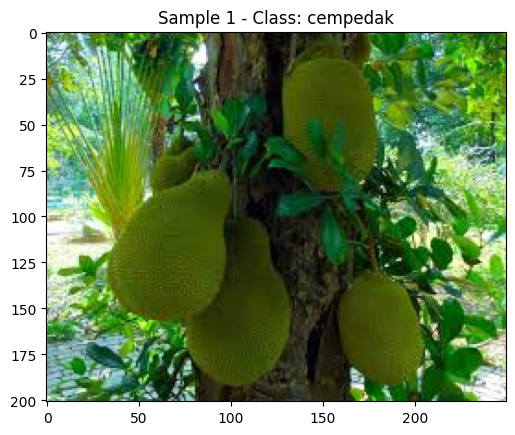

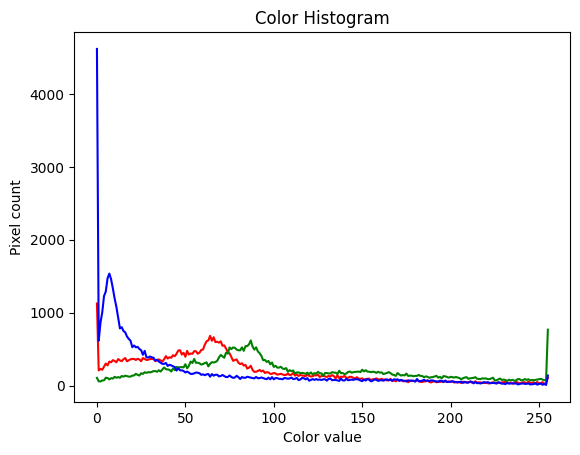

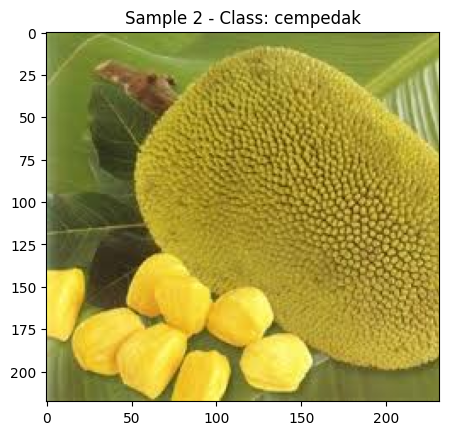

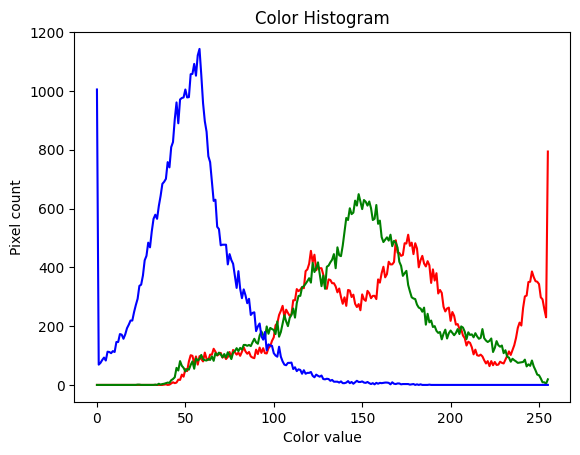

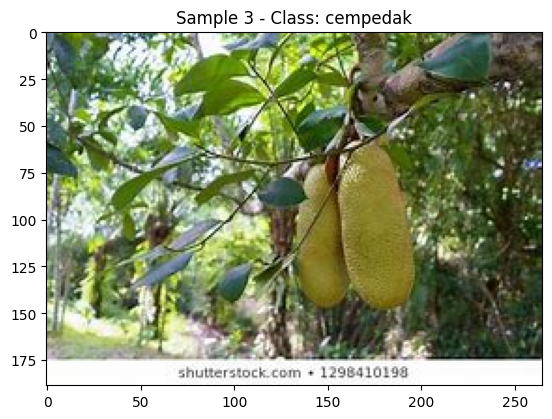

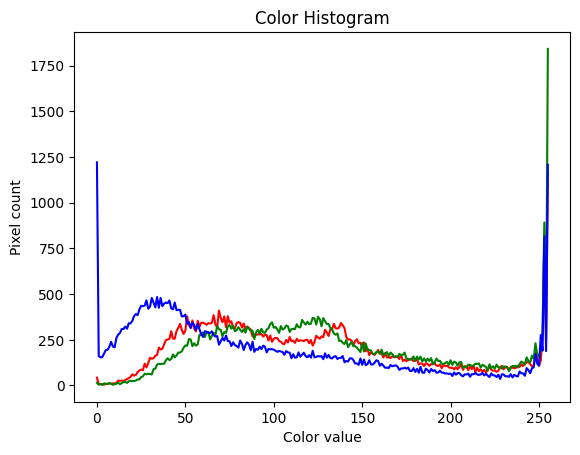

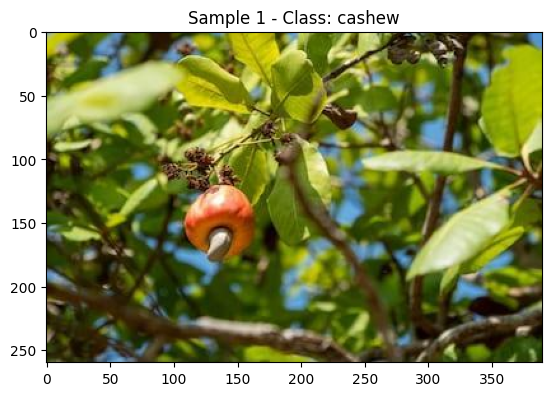

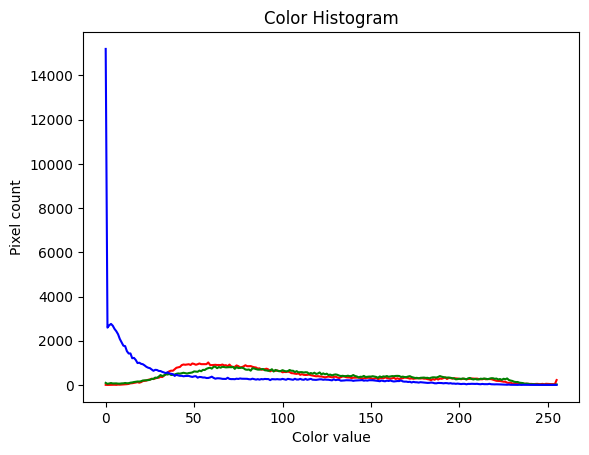

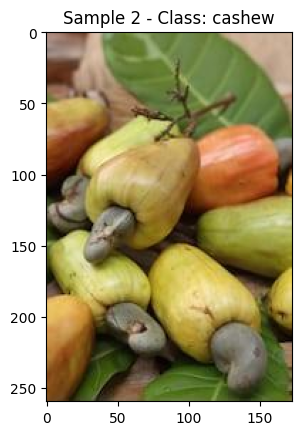

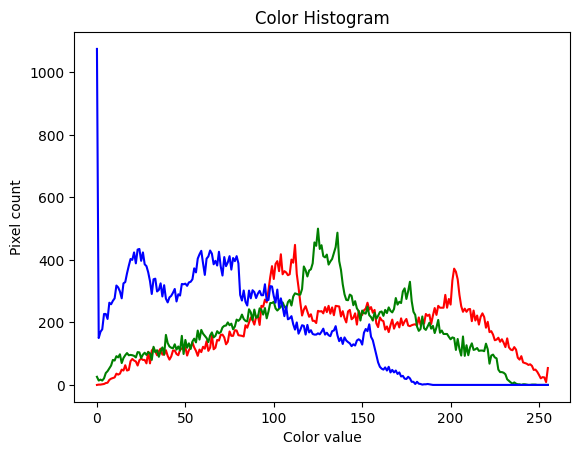

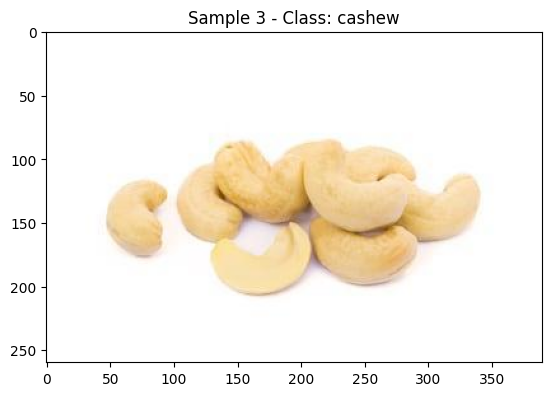

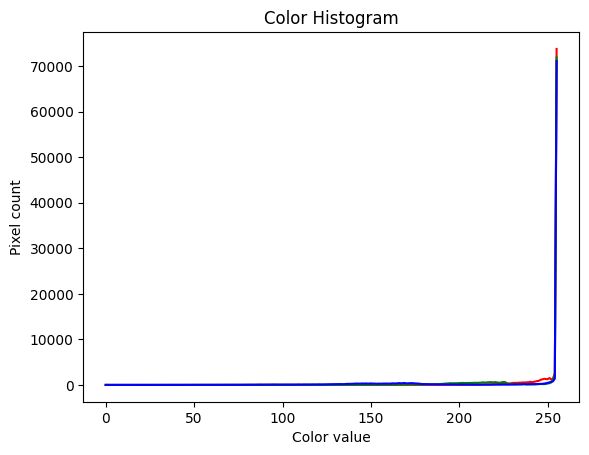

            Height        Width  Channels
count  1610.000000  1610.000000    1610.0
mean    231.452795   288.283851       3.0
std      78.943856   110.826611       0.0
min      75.000000   100.000000       3.0
25%     183.000000   210.000000       3.0
50%     225.000000   264.000000       3.0
75%     260.000000   389.000000       3.0
max     612.000000   833.000000       3.0
Training set size: 1288
Validation set size: 161
Test set size: 161


In [45]:
from sklearn.model_selection import train_test_split
# Load and explore the data
data = r"/kaggle/input/fruit2c/DATA2C/Dataset2C"
labels, image_paths = explore_image(data)

# Perform data augmentation if necessary

# Resize images to 224 x 224
resized_images = [cv2.resize(cv2.imread(img_path),(224, 224)) for img_path in image_paths]

# Split dataset into training, validation, and test sets
train_images, test_images, train_labels, test_labels = train_test_split(resized_images, labels, test_size=0.2, random_state=42)
val_images, test_images, val_labels, test_labels = train_test_split(test_images, test_labels, test_size=0.5, random_state=42)

# Verify the sizes of the datasets
print("Training set size:", len(train_images))
print("Validation set size:", len(val_images))
print("Test set size:", len(test_images))

In [46]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense

def VGG16(input_shape, num_classes):
    model = Sequential([
        Conv2D(64, (3, 3), activation='relu', padding='same', input_shape=input_shape),
        Conv2D(64, (3, 3), activation='relu', padding='same'),
        MaxPooling2D(pool_size=(2, 2), strides=(2, 2)),
        
        Conv2D(128, (3, 3), activation='relu', padding='same'),
        Conv2D(128, (3, 3), activation='relu', padding='same'),
        MaxPooling2D(pool_size=(2, 2), strides=(2, 2)),
        
        Conv2D(256, (3, 3), activation='relu', padding='same'),
        Conv2D(256, (3, 3), activation='relu', padding='same'),
        Conv2D(256, (3, 3), activation='relu', padding='same'),
        MaxPooling2D(pool_size=(2, 2), strides=(2, 2)),
        
        Conv2D(512, (3, 3), activation='relu', padding='same'),
        Conv2D(512, (3, 3), activation='relu', padding='same'),
        Conv2D(512, (3, 3), activation='relu', padding='same'),
        MaxPooling2D(pool_size=(2, 2), strides=(2, 2)),
        
        Conv2D(512, (3, 3), activation='relu', padding='same'),
        Conv2D(512, (3, 3), activation='relu', padding='same'),
        Conv2D(512, (3, 3), activation='relu', padding='same'),
        MaxPooling2D(pool_size=(2, 2), strides=(2, 2)),
        
        Flatten(),
        Dense(4096, activation='relu'),
        Dense(4096, activation='relu'),
        Dense(num_classes, activation='softmax')
    ])
    
    return model

# Define input shape and number of classes
input_shape = (224, 224, 3)  # Example input shape
num_classes = 4  # Example number of classes

# Create an instance of VGG16
model = VGG16(input_shape, num_classes)
model.summary()

/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_13 (Conv2D)              │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_14 (Conv2D)              │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_15 (Conv2D)              │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_16 (Conv2D)              │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_17 (Conv2D)              │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_18 (Conv2D)              │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_19 (Conv2D)              │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_20 (Conv2D)              │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_21 (Conv2D)              │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_22 (Conv2D)              │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_23 (Conv2D)              │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_24 (Conv2D)              │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_25 (Conv2D)              │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 4096)           │   102,764,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 4096)           │    16,781,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 4)              │        16,388 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 134,276,932 (512.23 MB)

 Trainable params: 134,276,932 (512.23 MB)

 Non-trainable params: 0 (0.00 B)

In [47]:
import numpy as np

# Convert data lists to numpy arrays__
train_images = np.array(train_images)
val_images = np.array(val_images)
test_images = np.array(test_images)

# Check the shapes of your data arrays
print("Train images shape:", train_images.shape)
print("Validation images shape:", val_images.shape)
print("Test images shape:", test_images.shape)


Train images shape: (1288, 224, 224, 3)
Validation images shape: (161, 224, 224, 3)
Test images shape: (161, 224, 224, 3)


In [48]:
# Convert labels to integer values
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.optimizers import Adam

label_encoder = LabelEncoder()
train_labels_encoded = label_encoder.fit_transform(train_labels)
val_labels_encoded = label_encoder.transform(val_labels)
test_labels_encoded = label_encoder.transform(test_labels)

model.compile(optimizer='Adam',loss='sparse_categorical_crossentropy',metrics=['accuracy'])
# Train the model
history = model.fit(train_images, train_labels_encoded,validation_data=(val_images, val_labels_encoded),epochs=10, batch_size=32)

# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(test_images,test_labels_encoded)
print('Test loss:', test_loss)
print('Test accuracy:', test_accuracy)

Epoch 1/10
41/41 ━━━━━━━━━━━━━━━━━━━━ 91s 1s/step - accuracy: 0.2405 - loss: 728.9831 - val_accuracy: 0.2298 - val_loss: 1.3860
Epoch 2/10
41/41 ━━━━━━━━━━━━━━━━━━━━ 16s 387ms/step - accuracy: 0.2561 - loss: 1.3914 - val_accuracy: 0.2422 - val_loss: 1.4717
Epoch 3/10
41/41 ━━━━━━━━━━━━━━━━━━━━ 16s 389ms/step - accuracy: 0.2329 - loss: 1.4041 - val_accuracy: 0.2298 - val_loss: 1.4087
Epoch 4/10
41/41 ━━━━━━━━━━━━━━━━━━━━ 16s 391ms/step - accuracy: 0.2719 - loss: 1.4016 - val_accuracy: 0.2112 - val_loss: 1.3891
Epoch 5/10
41/41 ━━━━━━━━━━━━━━━━━━━━ 16s 394ms/step - accuracy: 0.2447 - loss: 1.3854 - val_accuracy: 0.2112 - val_loss: 1.3892
Epoch 6/10
41/41 ━━━━━━━━━━━━━━━━━━━━ 16s 394ms/step - accuracy: 0.2595 - loss: 1.4268 - val_accuracy: 0.2298 - val_loss: 1.3899
Epoch 7/10
41/41 ━━━━━━━━━━━━━━━━━━━━ 16s 394ms/step - accuracy: 0.2479 - loss: 1.3878 - val_accuracy: 0.2298 - val_loss: 1.3884
Epoch 8/10
41/41 ━━━━━━━━━━━━━━━━━━━━ 16s 395ms/step - accuracy: 0.2641 - loss: 1.3859 - val_accur

In [49]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
y_pred = model.predict(test_images)
y_predict = np.argmax(y_pred, axis=1)
# Menghitung accuracy
accuracy = accuracy_score(test_labels_encoded, y_predict)
print("Accuracy:", accuracy)

# Menghitung precision, recall, dan F1-Score
precision, recall, f1_score, _ = precision_recall_fscore_support(test_labels_encoded, y_predict, average='weighted')
print("Precision:", precision)
print("Recall:", recall)
print("F1-Score:",f1_score)

6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 236ms/step
Accuracy: 0.2360248447204969
Precision: 0.055707727325334674
Recall: 0.2360248447204969
F1-Score: 0.09014014170230032


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [50]:
tf.keras.backend.clear_session()

In [51]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization

def Modified_VGG16(input_shape=(224, 224, 3), num_classes=4):
    model = Sequential([
        Conv2D(64, (3, 3), activation='relu', padding='same', input_shape=input_shape),
        BatchNormalization(),
        Conv2D(64, (3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPooling2D(pool_size=(2, 2), strides=(2, 2)),
        
        Conv2D(128, (3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        Conv2D(128, (3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPooling2D(pool_size=(2, 2), strides=(2, 2)),
        
        Conv2D(256, (3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        Conv2D(256, (3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        Conv2D(256, (3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPooling2D(pool_size=(2, 2), strides=(2, 2)),
        
        Conv2D(512, (3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        Conv2D(512, (3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        Conv2D(512, (3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPooling2D(pool_size=(2, 2), strides=(2, 2)),
        
        Conv2D(512, (3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        Conv2D(512, (3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        Conv2D(512, (3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPooling2D(pool_size=(2, 2), strides=(2, 2)),
        
        Flatten(),
        Dense(4096, activation='relu'),
        Dropout(0.5),
        Dense(4096, activation='relu'),
        Dropout(0.5),
        Dense(num_classes, activation='softmax')
    ])
    
    return model

# Create an instance of Modified_VGG16
model = Modified_VGG16()
model.summary()

/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 224, 224, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 224, 224, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 112, 112, 128)  │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 112, 112, 128)  │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 56, 56, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 56, 56, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 56, 56, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 28, 28, 512)    │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 28, 28, 512)    │         2,04

 Total params: 134,293,828 (512.29 MB)

 Trainable params: 134,285,380 (512.26 MB)

 Non-trainable params: 8,448 (33.00 KB)

In [52]:
# Check the length of x_train and y_train
print("Length of x_train:", len(train_images))
print("Length of y_train:", len(train_labels_encoded))

# Check the length of the validation set
print("Length of validation set:", len(val_images))

# Check the length of the test set
print("Length of test set:", len(test_images))


Length of x_train: 1288
Length of y_train: 1288
Length of validation set: 161
Length of test set: 161


In [53]:
# Convert labels to integer values
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.optimizers import Adam
label_encoder = LabelEncoder()
train_labels_encoded = label_encoder.fit_transform(train_labels)
val_labels_encoded = label_encoder.transform(val_labels)
test_labels_encoded = label_encoder.transform(test_labels)

model.compile(optimizer='Adam',loss='sparse_categorical_crossentropy',metrics=['accuracy'])
# Train the model
history = model.fit(train_images, train_labels_encoded,validation_data=(val_images, val_labels_encoded),epochs=15, batch_size=50)

# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(test_images,test_labels_encoded)
print('Test loss:', test_loss)
print('Test accuracy:', test_accuracy)

Epoch 1/15


W0000 00:00:1714359228.270090     107 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


25/26 ━━━━━━━━━━━━━━━━━━━━ 0s 688ms/step - accuracy: 0.3155 - loss: 52.6985

W0000 00:00:1714359252.625983     104 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 967ms/step - accuracy: 0.3172 - loss: 51.8445

W0000 00:00:1714359254.348570     107 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


26/26 ━━━━━━━━━━━━━━━━━━━━ 43s 1s/step - accuracy: 0.3188 - loss: 51.0537 - val_accuracy: 0.2422 - val_loss: 1756845.1250
Epoch 2/15
26/26 ━━━━━━━━━━━━━━━━━━━━ 19s 713ms/step - accuracy: 0.4482 - loss: 8.9726 - val_accuracy: 0.2609 - val_loss: 53348.0391
Epoch 3/15
26/26 ━━━━━━━━━━━━━━━━━━━━ 19s 721ms/step - accuracy: 0.4118 - loss: 7.9884 - val_accuracy: 0.2795 - val_loss: 564.9017
Epoch 4/15
26/26 ━━━━━━━━━━━━━━━━━━━━ 19s 729ms/step - accuracy: 0.4647 - loss: 2.8642 - val_accuracy: 0.2795 - val_loss: 82.2989
Epoch 5/15
26/26 ━━━━━━━━━━━━━━━━━━━━ 19s 747ms/step - accuracy: 0.5039 - loss: 1.8956 - val_accuracy: 0.4410 - val_loss: 21.3946
Epoch 6/15
26/26 ━━━━━━━━━━━━━━━━━━━━ 20s 762ms/step - accuracy: 0.4580 - loss: 1.7561 - val_accuracy: 0.4596 - val_loss: 13.9299
Epoch 7/15
26/26 ━━━━━━━━━━━━━━━━━━━━ 20s 768ms/step - accuracy: 0.5266 - loss: 1.3195 - val_accuracy: 0.4534 - val_loss: 2.9489
Epoch 8/15
26/26 ━━━━━━━━━━━━━━━━━━━━ 20s 775ms/step - accuracy: 0.5135 - loss: 1.1687 - val_ac

In [54]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
y_pred = model.predict(test_images)
y_predict = np.argmax(y_pred, axis=1)
# Menghitung accuracy
accuracy = accuracy_score(test_labels_encoded, y_predict)
print("Accuracy:", accuracy)

# Menghitung precision, recall, dan F1-Score
precision, recall, f1_score, _ = precision_recall_fscore_support(test_labels_encoded, y_predict, average='weighted')
print("Precision:", precision)
print("Recall:", recall)
print("F1-Score:",f1_score)

6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 293ms/step
Accuracy: 0.6583850931677019
Precision: 0.7341840270801322
Recall: 0.6583850931677019
F1-Score: 0.6587520689510462
